This tutorial demonstrates how to read in a particle stack in `cryospax`. The particle stack read here is given in [RELION](https://relion.readthedocs.io/en/release-5.0/) STAR file format.

After reading the particle stack, it is demonstrated how to compute a *power spectrum* using `cryojax`.

In [1]:
# JAX imports
import equinox as eqx
import jax.numpy as jnp

In [2]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryospax as spx

/Users/michael/venvs/cryojax-spa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First, we will read in the RELION particle stack using the `cryospax` particle stack loader [`cryospax.RelionParticleDataset`][].

!!! info "What is a `RelionParticleDataset`?"

    CryoSPAX implements an abstraction an a dataset in RELION, called a `RelionParticleDataset`. This object takes in a
    RELION STAR file for a particle stack. Upon accessing an image in the particle stack, a dictionary with keys 'parameters' and 'images' is returned.
    The parameters are also a dictionary with cryoJAX objects instantiated from the
    information in the STAR file, such as the contrast transfer function (the `AstigmaticCTF` class) and the pose (the `EulerAnglePose` class).

    More generally, a `RelionParticleDataset` is an `AbstractDataset`.
    This abstract interface are part of the `cryojax` public API!

In [4]:
# Read in the dataset and plot an image
parameter_file = spx.RelionParticleParameterFile(
    path_to_starfile="./data/ribosome_4ug0_particles.star",
    options=dict(
        loads_metadata=False,  # Set to `True` to load the raw starfile metadata
        loads_envelope=False,  # If `False`, assumes b_factor is 0 and CTF amplitude is 1
    ),
)
dataset = spx.RelionParticleDataset(parameter_file, path_to_relion_project="./")
# ... get the zeroth entry in the STAR file
particle_info = dataset[0]
eqx.tree_pprint(particle_info)

{
  'parameters':
  {
    'image_config':
    BasicImageConfig(
      shape=(100, 100),
      pixel_size=f32[](numpy),
      voltage_in_kilovolts=f32[](numpy),
      grid_helper=None,
      pad_options={'grid_helper': None, 'shape': (100, 100)}
    ),
    'pose':
    EulerAnglePose(
      offset_in_angstroms=f32[2](numpy),
      phi_angle=f32[](numpy),
      theta_angle=f32[](numpy),
      psi_angle=f32[](numpy)
    ),
    'transfer_theory':
    ContrastTransferTheory(
      ctf=AstigmaticCTF(
        defocus_in_angstroms=f32[](numpy),
        astigmatism_in_angstroms=f32[](numpy),
        astigmatism_angle=f32[](numpy),
        spherical_aberration_in_mm=f32[](numpy)
      ),
      envelope=None,
      amplitude_contrast_ratio=f32[](numpy),
      phase_shift=f32[](numpy)
    )
  },
  'images': f64[100,100](numpy)
}


Upon inspecting the zeroth element of the `RelionParticleDataset`, we see that a dict is returned with keys 'parameters' and 'images'. Let's grab the image, normalize it, plot it, and make sure the mean and standard deviation are zero and one, respectively.

/var/folders/37/7n3d9k7903zc8cy1_374smt00000gn/T/ipykernel_35390/3259882216.py:2: FutureWarning: 'normalize_image' is deprecated and has been renamed to 'standardize_image'. The old name will be deprecated in cryoJAX 0.6.0.
  from cryojax.ndimage import normalize_image


Image mean: 2.8991698e-08 Image standard deviation: 1.0000001


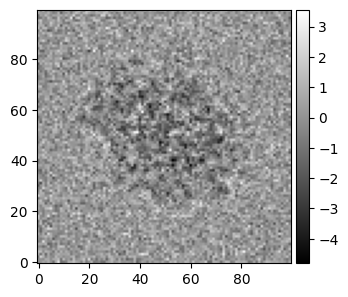

In [5]:
# Get an image, normalize, and plot it
from cryojax.ndimage import normalize_image


fig, ax = plt.subplots(figsize=(3.5, 3.5))
image = particle_info["images"]
normalized_image = normalize_image(image)
plot_image(normalized_image, fig, ax)
print(
    "Image mean:",
    normalized_image.mean(),
    "Image standard deviation:",
    normalized_image.std(),
)

This image happens to be simulated with `cryojax` from the structure of the human 80S ribosome (PDB id 4gu0).

We can also use fancy indexing to access multiple particles at once.

In [6]:
# Access multiple images in the stack
particle_info = dataset[0:3]
print(particle_info["images"].shape)

(3, 100, 100)


Now, we see that the `images` attribute has a leading dimension for each image. We can also inspect the parameters from the STAR file by printing the `CTF`.

In [7]:
# Inspect the CTF
parameters = particle_info["parameters"]
eqx.tree_pprint(parameters["transfer_theory"], short_arrays=False)

ContrastTransferTheory(
  ctf=AstigmaticCTF(
    defocus_in_angstroms=array([10025.484, 10025.484, 10025.484], dtype=float32),
    astigmatism_in_angstroms=array([50.970703, 50.970703, 50.970703], dtype=float32),
    astigmatism_angle=array([-54.58706, -54.58706, -54.58706], dtype=float32),
    spherical_aberration_in_mm=array([2.7, 2.7, 2.7], dtype=float32)
  ),
  envelope=None,
  amplitude_contrast_ratio=array([0.1, 0.1, 0.1], dtype=float32),
  phase_shift=array([0., 0., 0.], dtype=float32)
)


Notice that all attributes of the `CTF` have a leading dimension. For those familiar with RELION STAR format, even the `CTF` parameters not stored on a per-particle basis (the opticsGroup) have a leading dimension! This is for convenience working with `jax.vmap` transformations.

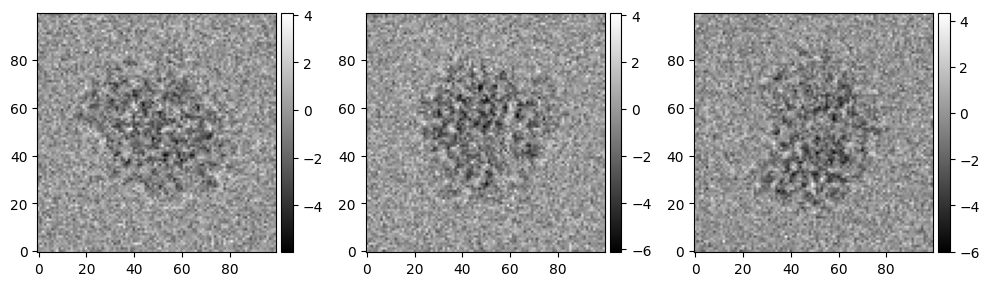

In [8]:
# Plot multiple images from the particle stack
fig, axes = plt.subplots(figsize=(10, 5), ncols=3)
[plot_image(particle_info["images"][idx], fig, axes[idx]) for idx in range(3)]
plt.tight_layout()

Computing the power spectrum of an image is a common analysis tool in cryo-EM. This can be done in `cryojax`!

First, we simply have to compute our image in fourier space and a grid of wave vector magnitudes.

(100, 100)


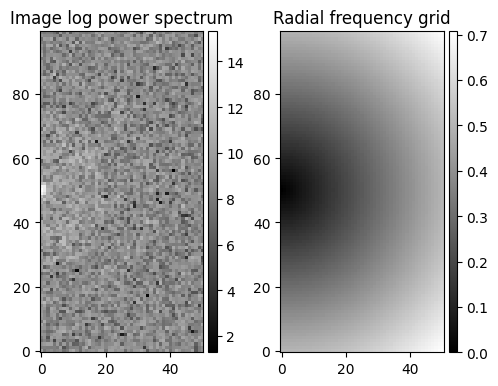

In [9]:
from cryojax.ndimage import rfftn


# Get the particle
particle_info = dataset[0]
image, parameters = particle_info["images"], particle_info["parameters"]
# ... and the image in fourier space
fourier_image = rfftn(image)
# ... and the cartesian coordinate system
pixel_size = float(parameters["image_config"].pixel_size)
print(image.shape)
frequency_grid_in_angstroms = parameters["image_config"].frequency_grid_in_angstroms
# ... now, compute a radial coordinate system
radial_frequency_grid_in_angstroms = jnp.linalg.norm(frequency_grid_in_angstroms, axis=-1)
# ... plot the image in fourier space and the radial frequency grid
fig, axes = plt.subplots(figsize=(5, 4), ncols=2)
plot_image(
    jnp.log(jnp.abs(jnp.fft.fftshift(fourier_image, axes=(0,))) ** 2),
    fig,
    axes[0],
    label="Image log power spectrum",
)
plot_image(
    jnp.fft.fftshift(radial_frequency_grid_in_angstroms * pixel_size, axes=(0,)),
    fig,
    axes[1],
    label="Radial frequency grid",
)
plt.tight_layout()

We are now ready to compute and plot the radially averaged power spectrum profile! This simply bins the squared fourier amplitudes according to the `radial_frequency_grid`.

[Text(0.5, 0, 'frequency magnitude $[\\AA^{-1}]$'),
 Text(0, 0.5, 'radially averaged power spectrum'),
 None]

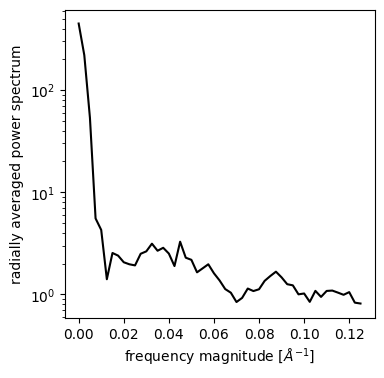

In [10]:
from cryojax.ndimage import compute_binned_powerspectrum


fig, ax = plt.subplots(figsize=(4, 4))
n_pixels = parameters["image_config"].n_pixels
spectrum, frequencies = compute_binned_powerspectrum(
    fourier_image,
    radial_frequency_grid_in_angstroms,
    pixel_size,
    maximum_frequency=1 / 2,
)
ax.plot(frequencies, spectrum / n_pixels, color="k")
ax.set(
    xlabel=r"frequency magnitude $[\AA^{-1}]$",
    ylabel="radially averaged power spectrum",
    yscale="log",
)

Here, we see that the Thon rings in our power spectrum are faint since the pixel since of our images is $4 \ \AA$.